In [1]:
%matplotlib inline

import datacube
from datacube.storage import masking

dc = datacube.Datacube(app='test_animation')

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# Near Cape Town South Africa

area_name = 'south_africa_monthly'
query = {'lat': (-33.72, -33.62), 'lon':(19.48, 19.60),
        'output_crs': 'EPSG:32734',
        'resolution': (-10,10),
        }
rgb_bands = ['red','green','blue']
band_index = 'ndvi'
clear_frac = 0.9
band_index_cmap = 'RdYlGn'
band_index_min, band_index_max = 0.1, 0.7
sensors = ['s2']
mask_cloud = False
percentile_stretch = (0.01, 0.98)
resample = '1M'
rolling = False
interval = 1000

In [17]:
area_name = 'etosha'

lat, lon = -18.68, 15.54
buffer_y = 0.1
buffer_x = 0.10

query = {'lat': (lat-buffer_y, lat+buffer_y), 
         'lon':(lon-buffer_x, lon+buffer_x),
        'output_crs': 'EPSG:32733',
        'resolution': (-10,10),
        'cloud_cover': (0, 10),
        }
all_bands = ['swir_1','nir','red', 'green', 'blue']
rgb_bands_1 = ['red','green','blue']
rgb_bands_2 = ['swir_1','nir','green']
#all_bands = ['swir_1','nir','red', 'green', 'blue']
#rgb_bands_1 = ['nir','red','green']
#rgb_bands_2 = ['swir_1','nir','blue']
band_index = None #'ndvi'
clear_frac = 0.9# 0.9
sensors = ['s2']
mask_cloud = False
percentile_stretch = (0.01, 0.995)
resample = None
rolling = False
interval = 500
best_per_month = True

In [18]:
import xarray as xr
import numpy as np
from skimage.morphology import disk, binary_dilation

bad = []

def load_and_combine(query, base_bands =['red','green','blue'], band_index = None, mask_cloud=True, best_per_month = True, masked = None,
                     dilation=0, clear_frac=0.8, sensors=[]):
    bands = base_bands.copy()
    if not band_index is None:
        if band_index.lower() == 'mndwi':
            if not 'green' in bands: bands += ['green']
            if not 'swir_1' in bands: bands += ['swir_1']
        if band_index.lower() == 'ndbi':
            if not 'nir' in bands: bands += ['nir']
            if not 'swir_1' in bands: bands += ['swir_1']
        if band_index.lower() == 'ndvi':
            if not 'nir' in bands: bands += ['nir']
            if not 'red' in bands: bands += ['red']
    
    datasets =[]
    for sensor in sensors:
        if sensor == 's2':
            product = 's2_l2a'
            if not 'SCL' in bands: bands += ["SCL"]
        else:
            product = 'ls%s_usgs_sr_scene'%sensor
        
        
        dss = dc.find_datasets(
            product=product, measurements=bands,**query)
        #print("Found %d datasets for Landsat %d."%(len(dss), sensor))
        for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
        print("Found %d good datasets for sensor %s."%(len(dss), sensor))
        if len(dss)==0:continue

        if (len(dss)>100 and (not 'time' in query)) or best_per_month:
            ds_set =[]
            time_slice = np.datetime64('2017-05')
            while time_slice < np.datetime64('now'):
                time_slice += np.timedelta64(1,'M')
                #for time_slice in [('2018-01-01','2018-06-30'),('2018-07-01','2018-12-31'),('2019-01-01','2019-06-30'),('2019-07-01','2019-12-31')]: #,('2020-01-01','2020-12-31')]:
                sub_query = query.copy()
                sub_query['time'] = str(time_slice)
                dss = dc.find_datasets(product=product, measurements=bands,**sub_query)
                for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
                print(f"Found {len(dss)} good datasets for sensor {sensor} for {time_slice}")
                if len(dss)==0:continue
                ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**sub_query)
                
                if product =='s2_l2a':
                    if not masked is None: mask = ds.SCL.isin([2,3,4,5,6,7,10,11]) | masked
                    else: mask = ds.SCL.isin([2,3,4,5,6,7,10,11])
                else:
                    pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**sub_query)
                    mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
                
                #if 'blue' in ds: mask = mask & (ds.blue<1000)
                if dilation >0:
                    mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
                good_frac = mask.mean(['x','y'])
                #print(good_frac.sel(time=(good_frac>=clear_frac)))
                if best_per_month:
                    if good_frac.max()< clear_frac: 
                        print('best image has good frac:', good_frac.max().values)
                        continue
                    good = good_frac == good_frac.max()
                else:
                    good = good_frac >= clear_frac
                if good.sum()==0: continue
                ds_clean = ds.isel(time=good)
                if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
                ds_clean = ds_clean.where(ds_clean>0,) 
                ds_clean['mask'] = mask.isel(time=good)
                ds_set.append(ds_clean.sortby('time'))
                print("Found %d clear observations for sensor %s."%(len(ds_clean.time), sensor))  
    
            ds_clean = xr.concat(ds_set, dim='time')
                    
        else:
            ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**query)
            if product =='s2_l2a':
                mask = good = ds.SCL.isin([2,4,5,6,7,11])
            else:
                pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**query)
                mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
            if 'blue' in ds: mask = mask & (ds.blue<1000)
            if dilation >0:
                mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
            good = mask.mean(['x','y']) >= clear_frac
            if good.sum()==0: continue
            ds_clean = ds.isel(time=good)
            if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
            ds_clean = ds_clean.where(ds_clean>0,) 
            ds_clean['mask'] = mask.isel(time=good)
            print("Found %d clear observations for sensor %s."%(len(ds_clean.time), sensor))
        
        if not band_index is None:
            if band_index.lower() == 'mndwi': 
                ds_clean[band_index] = (ds_clean.green-ds_clean.swir_1)/(ds_clean.green+ds_clean.swir_1)
            if band_index.lower() == 'ndbi':
                ds_clean[band_index] = (ds_clean.swir_1-ds_clean.nir)/(ds_clean.swir_1+ds_clean.nir)
            if band_index.lower() == 'ndvi':
                ds_clean[band_index] = (ds_clean.nir-ds_clean.red)/(ds_clean.nir+ds_clean.red)
        #ds_clean[band_index] = ds_clean[band_index].where(ds_clean.mask)
        #datasets = xr.concat([datasets, ds_clean], dim ='time')
        datasets.append(ds_clean)
    
    if len(datasets)==1:
        return datasets[0]
    elif len(datasets)>1:
        combined_ds = xr.concat(datasets, dim='time')
        combined_ds = combined_ds.sortby('time')
        return combined_ds
    else: return None
    

In [19]:
ds = load_and_combine(query, base_bands = all_bands, band_index = band_index, clear_frac=clear_frac, best_per_month=best_per_month,
                      mask_cloud=mask_cloud, sensors=sensors, 
                      masked = mask
                     )

Found 144 good datasets for sensor s2.
Found 3 good datasets for sensor s2 for 2017-06
Found 1 clear observations for sensor s2.
Found 6 good datasets for sensor s2 for 2017-07
Found 1 clear observations for sensor s2.
Found 6 good datasets for sensor s2 for 2017-08
Found 1 clear observations for sensor s2.
Found 4 good datasets for sensor s2 for 2017-09
Found 1 clear observations for sensor s2.
Found 6 good datasets for sensor s2 for 2017-10
Found 1 clear observations for sensor s2.
Found 5 good datasets for sensor s2 for 2017-11
Found 1 clear observations for sensor s2.
Found 2 good datasets for sensor s2 for 2017-12
Found 1 clear observations for sensor s2.
Found 3 good datasets for sensor s2 for 2018-01
Found 1 clear observations for sensor s2.
Found 3 good datasets for sensor s2 for 2018-02
Found 1 clear observations for sensor s2.
Found 1 good datasets for sensor s2 for 2018-03
Found 1 clear observations for sensor s2.
Found 4 good datasets for sensor s2 for 2018-04
Found 1 clear

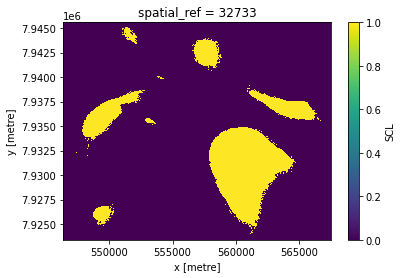

In [20]:
#check cloud issue
mask = (ds.SCL>=7).mean('time')>0.2
mask.plot.imshow();

In [16]:
mask

<xarray.DataArray 'SCL' (y: 2220, x: 2116)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    spatial_ref  int32 32733
  * y            (y) float64 7.946e+06 7.946e+06 ... 7.923e+06 7.923e+06
  * x            (x) float64 5.464e+05 5.464e+05 ... 5.675e+05 5.675e+05

In [ ]:
#ds.SCL.where(ds.SCL<10).where(ds.SCL>6).plot.imshow(col='time', col_wrap=10);

In [ ]:
ds.time.values

In [ ]:
#for a, b in zip(ds.time.values,ds.mask.groupby('time').mean().values):print(a,b)

In [ ]:
#if area_name == 'burundi':
#    good = ds[band_index].groupby('time').max().values >0.2
#    ds = ds.isel(time=good)

In [ ]:
if not best_per_month:
    ds.resample(time='1M').last().dropna('time', how='all')[rgb_bands].to_array().plot.imshow(col='time',col_wrap=4, robust=True);

In [21]:
#ds = ds[rgb_bands+[band_index]]
if resample:
    if not rolling:
        combined_ds = ds.resample(time=resample).median().dropna('time', how='all')
    else:
        combined_ds = ds.resample(time=resample).median().rolling(time=3, center=True, min_periods=1).median().dropna('time', how='all')
else:
    combined_ds = ds#.resample(time='1M').last().dropna('time', how='all')

In [ ]:
#combined_ds[rgb_bands].to_array().plot.imshow(col='time',col_wrap=4, robust=True);

In [ ]:
if band_index:
    combined_ds[band_index].plot.imshow(col='time',col_wrap=4,vmin=0.1, vmax=0.6, cmap=band_index_cmap, add_colorbar=False);

In [ ]:
if area_name == 'st_louis':
    combined_ds = combined_ds.isel(time=slice(28, len(combined_ds.time)))

In [23]:
#import sys
#sys.path.append("../Scripts")
#from deafrica_plotting import animated_timeseries, animated_doubletimeseries

from DEAPlotting import animated_timeseries, animated_doubletimeseries


if resample: date_type = 'M8[Y]'
else: date_type = 'M8[M]'

if band_index:
    animated_doubletimeseries(combined_ds[rgb_bands], combined_ds[[band_index]], '%s_with_%s.gif'%(area_name, band_index), 
                              width_pixels=1500, interval=interval, 
                              bands1=rgb_bands, bands2=[band_index],                               
                              percentile_stretch1 = percentile_stretch, percentile_stretch2 = percentile_stretch,
                              vmin_2 = band_index_min, vmax_2 = band_index_max,
                              image_proc_func1=None, image_proc_func2=None,
                              title1=combined_ds.time.values.astype(date_type), title2=band_index.upper(), #combined_ds.time.values.astype('M8[Y]'),
                              show_date1=False, show_date2=False, animation_options = {'repeat_delay': interval*2},
                              annotation_kwargs1={}, annotation_kwargs2={},
                              onebandplot_cbar1=True, onebandplot_cbar2=True,
                              onebandplot_kwargs1={}, onebandplot_kwargs2={'cmap':band_index_cmap},
                              shapefile_path1=None, shapefile_path2=None,
                              shapefile_kwargs1={}, shapefile_kwargs2={},
                              time_dim1 = 'time', x_dim1 = 'x', y_dim1 = 'y',
                              time_dim2 = 'time', x_dim2 = 'x', y_dim2 = 'y')

Generating 35 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to etosha_true_and_false.gif


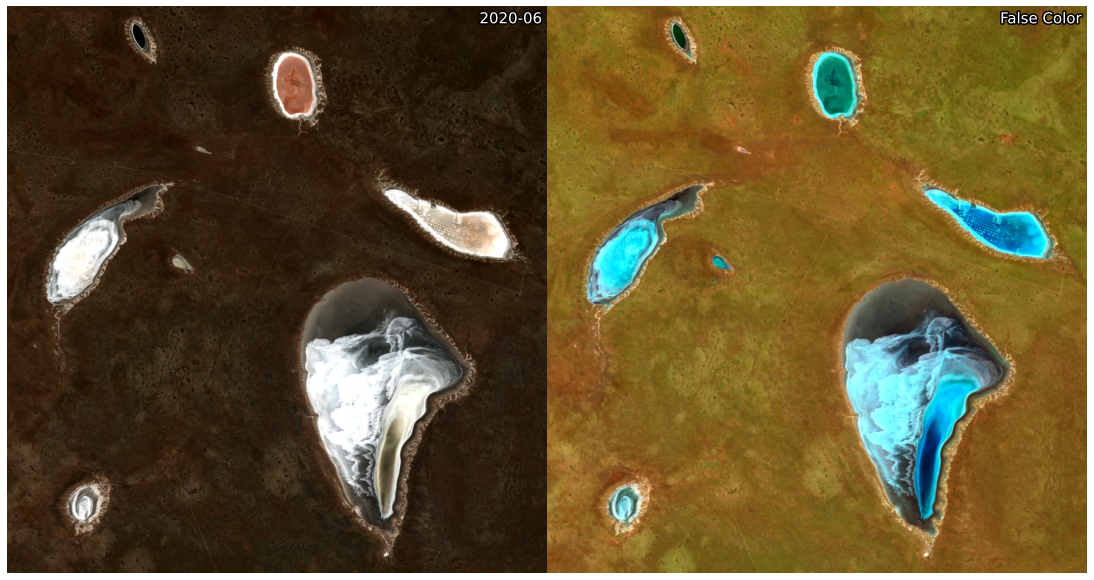

In [28]:
from DEAPlotting import *

def _ds_to_arrraylist(ds, bands, time_dim, x_dim, y_dim, percentile_stretch, image_proc_func=None, vmin=None, vmax=None): 

    """
    Converts an xarray dataset to a list of numpy arrays for plt.imshow plotting
    """

    if vmin is None and vmax is None:
        # Compute percents
        #p_lows, p_highs =[], []
        #for band in bands:
        #    p_low, p_high = ds[band].quantile(percentile_stretch).values
        #    p_lows.append(p_low)
        #    p_highs.append(p_high)
        #p_lows, p_highs = np.array([p_low]*len(bands)), np.array([p_high]*len(bands))
        #p_low, p_high = ds[bands].to_array().quantile(percentile_stretch).values
        #p_lows, p_highs = np.array([p_low]*len(bands)), np.array([p_high]*len(bands))
        #p_lows, p_highs = np.array(p_lows), np.array(p_highs)
        
        p_low, p_high = ds[bands].to_array().quantile(percentile_stretch).values
        p_lows, p_highs = np.array([p_low]*len(bands)), np.array([p_high]*len(bands))
        
    else:
        p_lows, p_highs = np.array([vmin]*len(bands)), np.array([vmax]*len(bands))
        
    array_list = []
    for i, timestep in enumerate(ds[time_dim]):

        # Select single timestep from the data array
        ds_i = ds[{time_dim: i}]

        # Get shape of array
        x = len(ds[x_dim])
        y = len(ds[y_dim])

        if len(bands) == 1:    

            # Create new one band array
            img_toshow = ds_i[bands[0]].values #exposure.rescale_intensity(ds_i[bands[0]].values, 
                                               #     in_range=(p_lows[0], p_highs[0]),
                                               #     out_range=(0, 1.0)) #'image')

        else:

            # Create new three band array                
            img_toshow = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                # Stretch contrast using percentile values
                img_toshow[:, :, band] = exposure.rescale_intensity(ds_i[colour].values, 
                                                    in_range=(p_lows[band], p_highs[band]),
                                                    out_range=(0, 1.0))

            # Optionally image processing
            if image_proc_func:
                
                img_toshow = image_proc_func(img_toshow).clip(0, 1)

        array_list.append(img_toshow)

    return array_list, p_lows.min(), p_highs.max()


def animated_doubletimeseries(ds1, ds2, output_path, 
                              width_pixels=1000, interval=200, 
                              bands1=['red', 'green', 'blue'], bands2=['red', 'green', 'blue'],                               
                              percentile_stretch1 = (0.02, 0.98), percentile_stretch2 = (0.02, 0.98),
                              vmin_1 = None, vmax_1 = None, vmin_2 = None, vmax_2 = None,
                              image_proc_func1=None, image_proc_func2=None,
                              title1=False, title2=False,
                              show_date1=True, show_date2=True, animation_options = {}, 
                              annotation_kwargs1={}, annotation_kwargs2={},
                              onebandplot_cbar1=True, onebandplot_cbar2=True,
                              onebandplot_kwargs1={}, onebandplot_kwargs2={},
                              shapefile_path1=None, shapefile_path2=None,
                              shapefile_kwargs1={}, shapefile_kwargs2={},
                              time_dim1 = 'time', x_dim1 = 'x', y_dim1 = 'y',
                              time_dim2 = 'time', x_dim2 = 'x', y_dim2 = 'y'):
    
    """
    Takes two xarray time series and animates both side-by-side as either three-band (e.g. true or false colour) 
    or single-band animations, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations for each panel or use different input bands from each dataset. For example, true and false 
    colour band combinations could be plotted at the same time, or different products (i.e. NBAR and NBART) or 
    cloud masking algorithms could be compared. 

    A shapefile boundary can be added to the output animation by providing a path to the shapefile.
    
    This function can be used to produce visually appealing cloud-free animations when used in combination with 
    the `load_clearlandsat` function from `dea-notebooks/10_Scripts/DEADataHandling`.
    
    Last modified: October 2018
    Author: Robbi Bishop-Taylor, Sean Chua, Bex Dunn
    
    :param ds1: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time_dim` dimension) to be 
        plotted in the left panel of the animation.
        
    :param ds2: 
        A matching xarray dataset with the same number of pixels as ds1, to be plotted in the right panel of the
        animation. ds1 and ds2 do not need to have exactly the same number of timesteps, but the animation will 
        only continue up until the length of the shorted dataset (i.e. if `ds1` has 10 timesteps and `ds2` has 5, 
        the animation will continue for 5 timesteps).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
        
    :param width_pixels:
        An optional integer defining the output width in pixels for the resulting animation. The height of the 
        animation is set automatically based on the dimensions/ratio of `ds1`. Defaults to 
        1000 pixels wide.
        
    :param interval:
        An optional integer defining the milliseconds between each animation frame used to control the speed of 
        the output animation. Higher values result in a slower animation. Defaults to 200 milliseconds between 
        each frame.
        
    :param bands1:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds1`.
        Defaults to `['red', 'green', 'blue']`.
    
    :param bands2:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds2`.
        Defaults to `['red', 'green', 'blue']`.        
      
    :param percentile_stretch1:        
        An optional tuple of two floats that can be used to clip one or three-band arrays in the left `ds1` panel
        by percentiles to produce a more vibrant, visually attractive image that is not affected by outliers/extreme 
        values. The default is `(0.02, 0.98)` which is equivalent to xarray's `robust=True`.
    
    :param percentile_stretch2:
        An optional tuple of two floats that can be used to clip one or three-band arrays in the right `ds2` panel
        by percentiles to produce a more vibrant, visually attractive image that is not affected by outliers/extreme 
        values. The default is `(0.02, 0.98)` which is equivalent to xarray's `robust=True`.
        
    :param image_proc_func1:
        An optional function can be passed to modify three-band arrays in the left `ds1` panel for each timestep 
        prior to animating. This could include image processing functions such as increasing contrast, unsharp 
        masking, saturation etc. The function should take AND return a three-band numpy array with shape [:, :, 3]. 
        If your function has parameters, you can pass in custom values using `partial` from `functools`: 
        `image_proc_func=partial(custom_func, param1=10)`.
        
    :param image_proc_func2:
        An optional function can be passed to modify three-band arrays in the right `ds1` panel for each timestep 
        prior to animating. This could include image processing functions such as increasing contrast, unsharp 
        masking, saturation etc. The function should take AND return a three-band numpy array with shape [:, :, 3]. 
        If your function has parameters, you can pass in custom values using `partial` from `functools`: 
        `image_proc_func=partial(custom_func, param1=10)`.

    :param title1: 
        An optional string or list of strings with a length equal to the number of timesteps in `ds1`. This can be
        used to display a static title for the left panel (using a string), or a dynamic title (using a list)
        that displays different text for each timestep. Defaults to False, which plots no title.
        
    :param title2: 
        An optional string or list of strings with a length equal to the number of timesteps in `ds2`. This can be
        used to display a static title for the left panel (using a string), or a dynamic title (using a list)
        that displays different text for each timestep. Defaults to False, which plots no title.
        
    :param show_date1:
        An optional boolean that defines whether or not to plot date annotations for each animation frame in the 
        left panel. Defaults to True, which plots date annotations for `ds1`.
    
    :param show_date2:
        An optional boolean that defines whether or not to plot date annotations for each animation frame in the 
        right panel. Defaults to True, which plots date annotations for `ds2`.

    :param annotation_kwargs1:
        An optional dict of kwargs for controlling the appearance of `ds1` text annotations to pass to 
        matplotlib `plt.annotate`  (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html). 
        For example, `annotation_kwargs1={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text 
        annotations are white, size 15 mono-spaced font with a 3pt black outline in the panel's top-right. 
    
    :param annotation_kwargs2:
        An optional dict of kwargs for controlling the appearance of the `ds2` text annotations to pass 
        to matplotlib `plt.annotate` (see above).
        
    :param onebandplot_cbar1:
        An optional boolean indicating whether to include a colourbar if `ds1` is a one-band array. Defaults to True.
        
    :param onebandplot_cbar2:
        An optional boolean indicating whether to include a colourbar if `ds2` is a one-band array. Defaults to True.
        
    :param onebandplot_kwargs1:
        An optional dict of kwargs for controlling the appearance of `ds1` one-band image arrays to pass to 
        matplotlib `plt.imshow` (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options).
        This only applies if an xarray with a single band is passed to d1. For example, a green colour scheme and
        custom stretch can be specified using: `onebandplot_kwargs1={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`. 
        By default, one-band arrays are plotted using the 'Greys' cmap with bilinear interpolation.
        
        Two special kwargs (`tick_fontsize`, `tick_colour`) can also be passed to control the tick labels on the 
        colourbar. This can be useful for example when the tick labels are difficult to see against a dark background.
    
    :param onebandplot_kwargs2:
        An optional dict of kwargs for controlling the appearance of `ds2` one-band image arrays to 
        pass to matplotlib `plt.imshow`; only applies if an xarray with a single band is passed to `d2` (see above).

    :param shapefile_path1:
        An optional string or list of strings giving the file paths of shapefiles to overlay on the left `ds1` panel. 
        The shapefiles must be in the same projection as the input xarray dataset.

    :param shapefile_path2:
        An optional string or list of strings giving the file paths of shapefiles to overlay on the right `ds2` panel. 
        The shapefiles must be in the same projection as the input xarray dataset.
        
    :param shapefile_kwargs1:
        An optional dict of kwargs to specify the appearance of the left `ds1` panel shapefile overlay to pass to 
        `GeoSeries.plot` (see http://geopandas.org/reference.html#geopandas.GeoSeries.plot). For example: 
         `shapefile_kwargs = {'linewidth':2, 'edgecolor':'black', 'facecolor':"#00000000"}`

    :param shapefile_kwargs2:
        An optional dict of kwargs to specify the appearance of the right `ds2` panelshapefile overlay. For example: 
        `shapefile_kwargs = {'linewidth':2, 'edgecolor':'black', 'facecolor':"#00000000"}`
        
    :param time_dim1:
        An optional string allowing you to override the xarray dimension used for time in `ds1`. 
        Defaults to 'time'.
    
    :param time_dim2:
        An optional string allowing you to override the xarray dimension used for time in `ds2`. 
        Defaults to 'time'.
    
    :param x_dim1:
        An optional string allowing you to override the xarray dimension used for x coordinates in `ds1`. 
        Defaults to 'x'.
        
    :param x_dim2:
        An optional string allowing you to override the xarray dimension used for x coordinates in `ds2`. 
        Defaults to 'x'.
    
    :param y_dim1:
        An optional string allowing you to override the xarray dimension used for y coordinates in `ds1`. 
        Defaults to 'y'
    
    :param y_dim2:
        An optional string allowing you to override the xarray dimension used for y coordinates in `ds2`. 
        Defaults to 'y'
        
    """
    
    ###############
    # Setup steps #
    ###############
    
    # Test if all dimensions exist in dataset
    if time_dim1 in ds1 and x_dim1 in ds1 and y_dim1 in ds1 and time_dim2 in ds2 and x_dim2 in ds2 and y_dim2 in ds2:
        
        # First test if there are three bands, and that all exist in both datasets:
        if ((len(bands1) == 3) | (len(bands1) == 1)) & all([(b1 in ds1.data_vars) for b1 in bands1]) & \
           ((len(bands2) == 3) | (len(bands2) == 1)) & all([(b2 in ds2.data_vars) for b2 in bands2]):  
    
            # Import xarrays as lists of three band numpy arrays
            imagelist1, vmin1, vmax1 = _ds_to_arrraylist(ds1, bands=bands1, 
                                                         time_dim=time_dim1, x_dim=x_dim1, y_dim=y_dim1, 
                                                         percentile_stretch=percentile_stretch1, vmin=vmin_1, vmax=vmax_1,
                                                         image_proc_func=image_proc_func1)
            imagelist2, vmin2, vmax2 = _ds_to_arrraylist(ds2, bands=bands2, 
                                                         time_dim=time_dim2, x_dim=x_dim2, y_dim=y_dim2, 
                                                         percentile_stretch=percentile_stretch2, vmin=vmin_2, vmax=vmax_2,
                                                         image_proc_func=image_proc_func2)
    
            # Get time, x and y dimensions of dataset 
            timesteps1 = len(ds1[time_dim1])  
            timesteps2 = len(ds2[time_dim2])
            width1 = len(ds1[x_dim1])
            width2 = len(ds2[x_dim2])
            height1 = len(ds1[y_dim1])
            height2 = len(ds2[y_dim2])

            # Calculate width vs height of plot
            width_ratio = float(width1) / float(height1)
            width = 15.0
            height = width / width_ratio

            # If title is supplied as a string, multiply out to a list with one string per timestep.
            # Otherwise, use supplied list for plot titles.
            if isinstance(title1, str) or isinstance(title1, bool):
                title_list1 = [title1] * timesteps1   
            else:
                title_list1 = title1

            # If title is supplied as a string, multiply out to a list with one string per timestep
            if isinstance(title2, str) or isinstance(title2, bool):
                title_list2 = [title2] * timesteps2  
            else:
                title_list2 = title2       

            # Set up annotation parameters that plt.imshow plotting for single band array images. 
            # The nested dict structure sets default values which can be overwritten/customised by the 
            # manually specified `onebandplot_kwargs`
            onebandplot_kwargs1 = dict({'cmap':'Greys', 'interpolation':'bilinear',                                  
                                        'vmin':vmin1, 'vmax':vmax1, 'tick_colour': 'black', 'tick_fontsize': 11},
                                        **onebandplot_kwargs1) 
            
            # Use pop to remove the two special tick kwargs from the onebandplot_kwargs dict, and save individually
            onebandplot_tick_colour1 = onebandplot_kwargs1.pop('tick_colour')
            onebandplot_tick_fontsize1 = onebandplot_kwargs1.pop('tick_fontsize')

            onebandplot_kwargs2 = dict({'cmap':'Greys', 'interpolation':'bilinear',
                                        'vmin':vmin2, 'vmax':vmax2, 'tick_colour': 'black', 'tick_fontsize': 11},
                                        **onebandplot_kwargs2) 
            
            # Use pop to remove the two special tick kwargs from the onebandplot_kwargs dict, and save individually
            onebandplot_tick_colour2 = onebandplot_kwargs2.pop('tick_colour')
            onebandplot_tick_fontsize2 = onebandplot_kwargs2.pop('tick_fontsize')

            # Set up annotation parameters that control font etc. The nested dict structure sets default 
            # values which can be overwritten/customised by the manually specified `annotation_kwargs`
            annotation_kwargs1 = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                                       'xytext':(-5, -5), 'textcoords':'offset points', 
                                       'horizontalalignment':'right', 'verticalalignment':'top', 
                                       'fontsize':15, 'color':'white', 
                                       'path_effects':[PathEffects.withStroke(linewidth=3, foreground='black')]},
                                       **annotation_kwargs1)

            annotation_kwargs2 = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                                       'xytext':(-5, -5), 'textcoords':'offset points', 
                                       'horizontalalignment':'right', 'verticalalignment':'top', 
                                       'fontsize':15, 'color':'white', 
                                       'path_effects':[PathEffects.withStroke(linewidth=3, foreground='black')]},
                                       **annotation_kwargs2)

            # Define default plotting parameters for the overlaying shapefile(s). The nested dict structure sets 
            # default values which can be overwritten/customised by the manually specified `shapefile_kwargs`
            shapefile_kwargs1 = dict({'linewidth': 2, 'edgecolor': 'black', 'facecolor': "#00000000"}, 
                                     **shapefile_kwargs1) 

            shapefile_kwargs2 = dict({'linewidth': 2, 'edgecolor': 'black', 'facecolor': "#00000000"}, 
                                     **shapefile_kwargs2) 
            

            ###################
            # Initialise plot #
            ################### 
        
            # Set up figure
            fig, (ax1, ax2) = plt.subplots(ncols=2) 
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
            fig.set_size_inches(width, height * 0.5, forward=True)
            ax1.axis('off')
            ax2.axis('off')

            # Initialise axesimage objects to be updated during animation
            extents1 = [float(ds1[x_dim1].min()), float(ds1[x_dim1].max()), 
                        float(ds1[y_dim1].min()), float(ds1[y_dim1].max())]
            extents2 = [float(ds2[x_dim2].min()), float(ds2[x_dim2].max()), 
                        float(ds2[y_dim2].min()), float(ds2[y_dim2].max())]
            im1 = ax1.imshow(imagelist1[0], extent=extents1, **onebandplot_kwargs1)
            im2 = ax2.imshow(imagelist2[0], extent=extents2, **onebandplot_kwargs2)

            # Initialise annotation objects to be updated during animation
            t1 = ax1.annotate('', **annotation_kwargs1)   
            t2 = ax2.annotate('', **annotation_kwargs2)  


            #########################
            # Add optional overlays #
            #########################        

            # Optionally add shapefile overlay(s) from either string path or list of string paths
            if isinstance(shapefile_path1, str):

                shapefile = gpd.read_file(shapefile_path1)
                shapefile.plot(**shapefile_kwargs1, ax=ax1)

            elif isinstance(shapefile_path1, list):

                # Iterate through list of string paths
                for shapefile in shapefile_path1:

                    shapefile = gpd.read_file(shapefile)
                    shapefile.plot(**shapefile_kwargs1, ax=ax1) 

            # Optionally add shapefile overlay(s) from either string path or list of string paths
            if isinstance(shapefile_path2, str):

                shapefile = gpd.read_file(shapefile_path2)
                shapefile.plot(**shapefile_kwargs2, ax=ax2)

            elif isinstance(shapefile_path2, list):

                # Iterate through list of string paths
                for shapefile in shapefile_path2:

                    shapefile = gpd.read_file(shapefile)
                    shapefile.plot(**shapefile_kwargs2, ax=ax2) 

            # After adding shapefile, fix extents of plot
            ax1.set_xlim(extents1[0], extents1[1])
            ax1.set_ylim(extents1[2], extents1[3])
            ax2.set_xlim(extents2[0], extents2[1])
            ax2.set_ylim(extents2[2], extents2[3])

            # Optionally add colourbars for one band images
            if (len(bands1) == 1) & onebandplot_cbar1:                
                _add_colourbar(ax1, im1, 
                               tick_fontsize=onebandplot_tick_fontsize1,
                               tick_colour=onebandplot_tick_colour1,
                               vmin=onebandplot_kwargs1['vmin'], 
                               vmax=onebandplot_kwargs1['vmax'])

            if (len(bands2) == 1) & onebandplot_cbar2:                
                _add_colourbar(ax2, im2, 
                               tick_fontsize=onebandplot_tick_fontsize2,
                               tick_colour=onebandplot_tick_colour2,
                               vmin=onebandplot_kwargs2['vmin'], 
                               vmax=onebandplot_kwargs2['vmax'])

            # Function to update figure
            def update_figure(frame_i):

                ####################
                # Plot first panel #
                ####################  

                # If possible, extract dates from time dimension
                try:

                    # Get human-readable date info (e.g. "16 May 1990")
                    ts = ds1[time_dim1][{time_dim1:frame_i}].dt
                    year = ts.year.item()
                    month = ts.month.item()
                    day = ts.day.item()
                    date_string = '{} {} {}'.format(day, calendar.month_abbr[month], year)

                except:

                    date_string = ds1[time_dim1][{time_dim1:frame_i}].values.item()

                # Create annotation string based on title and date specifications:
                title1 = title_list1[frame_i]
                if title1 and show_date1:
                    title_date1 = '{}\n{}'.format(date_string, title1)
                elif title1 and not show_date1:
                    title_date1 = '{}'.format(title1)
                elif show_date1 and not title1:
                    title_date1 = '{}'.format(date_string)           
                else:
                    title_date1 = ''

                # Update figure for frame
                im1.set_array(imagelist1[frame_i])
                t1.set_text(title_date1) 


                #####################
                # Plot second panel #
                ##################### 

                # If possible, extract dates from time dimension
                try:

                    # Get human-readable date info (e.g. "16 May 1990")
                    ts = ds2[time_dim2][{time_dim2:frame_i}].dt
                    year = ts.year.item()
                    month = ts.month.item()
                    day = ts.day.item()
                    date_string = '{} {} {}'.format(day, calendar.month_abbr[month], year)

                except:

                    date_string = ds2[time_dim2][{time_dim2:frame_i}].values.item()

                # Create annotation string based on title and date specifications:
                title2 = title_list2[frame_i]
                if title2 and show_date2:
                    title_date2 = '{}\n{}'.format(date_string, title2)
                elif title2 and not show_date2:
                    title_date2 = '{}'.format(title2)
                elif show_date2 and not title2:
                    title_date2 = '{}'.format(date_string)         
                else:
                    title_date2 = ''

                # Update figure for frame
                im2.set_array(imagelist2[frame_i])
                t2.set_text(title_date2) 

                # Return the artists set
                return [im1, im2, t1, t2]


            ##############################
            # Generate and run animation #
            ##############################

            # Generate animation
            frames_to_run = min(timesteps1, timesteps2)
            print('Generating {} frame animation (i.e. timesteps in shortest dataset)'.format(frames_to_run))
            ani = animation.FuncAnimation(fig, update_figure, frames=frames_to_run, interval=interval, blit=True, **animation_options)

            # Export as either MP4 or GIF
            if output_path[-3:] == 'mp4':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=72)

            elif output_path[-3:] == 'gif':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path,
                         writer='pillow') 

            else:
                print('    Output file type must be either .mp4 or .gif')

        else:        
            print('Please select either one or three bands that all exist in the input datasets')  
            
    else:
        print('At least one x, y or time dimension does not exist in `ds1` or `ds2`. Please use the `time_dim`,' \
              '`x_dim` or `y_dim` parameters to override the default dimension names used for plotting') 

        
if all_bands:
    animated_doubletimeseries(combined_ds[rgb_bands_1], combined_ds[rgb_bands_2], '%s_true_and_false.gif'%(area_name), 
                              width_pixels=1500, interval=interval, 
                              bands1=rgb_bands_1, bands2=rgb_bands_2,                               
                              percentile_stretch1 = percentile_stretch, percentile_stretch2 = percentile_stretch,
                              #vmin_2 = band_index_min, vmax_2 = band_index_max,
                              image_proc_func1=None, image_proc_func2=None,
                              title1=combined_ds.time.values.astype(date_type), 
                              title2='False Color', #combined_ds.time.values.astype('M8[Y]'),
                              show_date1=False, show_date2=False, animation_options = {'repeat_delay': interval*2},
                              annotation_kwargs1={}, annotation_kwargs2={},
                              onebandplot_cbar1=True, onebandplot_cbar2=True,
                              onebandplot_kwargs1={}, onebandplot_kwargs2= {},#{'cmap':band_index_cmap},
                              shapefile_path1=None, shapefile_path2=None,
                              shapefile_kwargs1={}, shapefile_kwargs2={},
                              time_dim1 = 'time', x_dim1 = 'x', y_dim1 = 'y',
                              time_dim2 = 'time', x_dim2 = 'x', y_dim2 = 'y')